**Importing Dependencies**

In [39]:
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import pygame
import pygame.gfxdraw

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

from collections import deque

# Import stable baselines
# Probably not needed
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

**Building the environment**

Description of the environemnt:

- Lorem
- Lorem
- Lorem

Is there a length definition for the class? For how long should the simulation run?

What is the initial state of the environment?

In [4]:
Box(low=np.array([0]), high=np.array([100]), dtype=np.int64)

Box(0, 100, (1,), int64)

In [47]:
class SS_Mngmt_Env(Env):

    metadata = {"render_modes": ["human"], "render_fps": 4}
    
    # Define the action and observation space
    def __init__(self, render_mode = None):

        self.I0 = 30 # Initial stock level
        self.stockout_cost = 100 # Cost of stockout
        self.demand = 6 # Demand for production

        # Order delay and queue
        self.order_delay = 3
        self.order_queue = deque(maxlen=self.order_delay)

        # To implement
        # self.order_cost = 10 # Cost of ordering stock
        # self.holding_cost = 1 # Cost of holding stock
        # unit cost
        
        # Define action space
        # Change the action space for different campaign sizes
        self.action_space = Discrete(10)
        
        # Define observation space (Stock level) --> to add expected demand, etc.
        self.observation_space = Box(low=np.array([0]), 
                                     high=np.array([100]),
                                     dtype=np.int64)

        # Define the initial state
        self.state = self.I0

        # Length of the episode
        self.episode_length = 29

        # History
        self.stock_history = []
        self.demand_history = []
        self.order_history = []

        # Empty dataframe for plotting the history
        self.history = pd.DataFrame(columns = ['Stock Level', 'Order', 'Demand'])

        self.render_mode = render_mode
        self.screen_initialized = False


    # Defining the step function
    def step(self, action):
        # Returns the next state, reward and whether the episode is done

        # action is the amount of stock to order
        # state is the current stock level
        # reward is the cost of the stock

        # Initialize the reward
        reward = 0

        # Demand for production --> random for now
        self.demand = 6 + random.randint(-5, 5)

        # Subtract the demand from the stock
        self.state = self.state - self.demand

        # To Do: Implement the cost of ordering stock
        # To Do: Campaign Size

        # Add the order to the queue
        self.order_queue.append(action)

        # If there are enough steps passed since the order was placed, add the order to the stock
        if len(self.order_queue) == self.order_delay:
            self.state += self.order_queue.popleft()

        # Check if the stock level is negative
        if self.state < 0:
            # If the stock level is negative, the cost is the stockout cost
            reward = -self.stockout_cost

        # Calculate the cost of the stock
        # Reward is negative since we want to minimize the cost
        reward = float(reward -(self.state))

        # Check if the episode is done
        done = self.episode_length == 0

        # Decrease the episode length
        self.episode_length -= 1

        obs = np.array([self.state])

        # Append the state to the history
        self.stock_history.append(self.state)
        self.demand_history.append(self.demand)

        # Set placeholder for info
        info = {}

        # Check if the episode is truncated
        truncated = False

        return obs, reward, done, truncated, info

    def render(self):
        if self.render_mode is not None:
            if self.render_mode == "human":
                self.render_human()

    def render_human(self):
        # Render the environment
        # Provide a visual representation of the environment the stock level
        # Stock level in y axis and time in x axis

        plt.clf()
        
        plt.plot(self.stock_history)
        plt.ylabel('Stock Level')
        plt.xticks(np.arange(0, 30, step=5))
        plt.yticks(np.arange(0, 100, step=10))
        plt.xlabel('Time')
        plt.draw()
        plt.pause(0.01)
        
        return
    
    # def render_human(self):

    #     if not self.screen_initialized:
    #         # Initialize Pygame only once
    #         pygame.init()
    #         self.width, self.height = 800, 600
    #         self.screen = pygame.display.set_mode((self.width, self.height))
    #         self.font = pygame.font.SysFont('Arial', 18)
    #         self.screen_initialized = True

    #     # Clear the screen
    #     self.screen.fill((255, 255, 255))

    #     # Draw axes
    #     pygame.draw.line(self.screen, (0, 0, 0), (50, self.height - 50), (self.width - 50, self.height - 50))  # x-axis
    #     pygame.draw.line(self.screen, (0, 0, 0), (50, self.height - 50), (50, 50))  # y-axis

    #     # Add labels to the axes
    #     x_label = self.font.render('Iterations', True, (0, 0, 0))
    #     y_label = self.font.render('Stock Level', True, (0, 0, 0))
    #     self.screen.blit(x_label, (self.width // 2, self.height - 30))
    #     self.screen.blit(y_label, (10, self.height // 2))

    #     # Rotate the y-axis label
    #     y_label = pygame.transform.rotate(y_label, 90)

    #     # Draw grid lines
    #     for x in range(100, self.width - 50, 50):
    #         pygame.draw.line(self.screen, (200, 200, 200), (x, 50), (x, self.height - 50))
    #     for y in range(100, self.height - 50, 50):
    #         pygame.draw.line(self.screen, (200, 200, 200), (50, y), (self.width - 50, y))

    #     # Scale the history to fit the window
    #     if self.stock_history:
    #         max_stock = max(self.stock_history) if self.stock_history else 1
    #         scaled_history = [(i * (self.width - 100) / len(self.stock_history) + 50,
    #                            self.height - (s * (self.height - 100) / max_stock + 50)) for i, s in enumerate(self.stock_history)]

    #         # Draw the history
    #         for i in range(1, len(scaled_history)):
    #             pygame.draw.line(self.screen, (0, 0, 0), scaled_history[i-1], scaled_history[i], 2)

    #         # Draw data points
    #         for point in scaled_history:
    #             pygame.draw.circle(self.screen, (0, 0, 255), (int(point[0]), int(point[1])), 5)

    #     # Update the display
    #     pygame.display.flip()

    #     # Pause for a short period to allow the plot to update
    #     pygame.time.wait(100)

    #     return

    def close(self):
        pygame.display.quit()
        pygame.quit()

    def reset(self, seed = None):
        # Reset the state of the environment back to an initial state

        super().reset(seed = seed) # Reset the seed
        if seed is not None:
            random.seed(seed)

        # Reset the state
        self.state = 50 + random.randint(-20, 20)

        # Reset the episode length
        self.episode_length = 30

        # Reset the order queue
        self.order_queue.clear()

        obs = np.array([self.state])

        # # Append history to the dataframe
        # self.history['Stock Level'] = self.stock_history
        # self.history['Order'] = self.stock_history
        # self.history['Demand'] = self.demand_history

        # Reset the history
        self.stock_history = []
        self.order_history = []
        self.demand_history = []

        # Placeholder for info
        info = {}

        return obs, info


**Testng the environment**

In [40]:
from stable_baselines3.common.env_checker import check_env

env = SS_Mngmt_Env(render_mode="human")
check_env(env, warn=True)

In [41]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        # env.render()
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score+=reward

        print('Step:{} Score:{} Stock:{} Order:{} Demand:{}'.format(env.episode_length, score, n_state, action, env.demand))

Step:29 Score:-45.0 Stock:[45] Order:5 Demand:3
Step:28 Score:-88.0 Stock:[43] Order:2 Demand:2
Step:27 Score:-126.0 Stock:[38] Order:3 Demand:10
Step:26 Score:-161.0 Stock:[35] Order:2 Demand:5
Step:25 Score:-190.0 Stock:[29] Order:8 Demand:9
Step:24 Score:-211.0 Stock:[21] Order:9 Demand:10
Step:23 Score:-237.0 Stock:[26] Order:3 Demand:3
Step:22 Score:-267.0 Stock:[30] Order:5 Demand:5
Step:21 Score:-298.0 Stock:[31] Order:7 Demand:2
Step:20 Score:-332.0 Stock:[34] Order:2 Demand:2
Step:19 Score:-362.0 Stock:[30] Order:6 Demand:11
Step:18 Score:-388.0 Stock:[26] Order:3 Demand:6
Step:17 Score:-412.0 Stock:[24] Order:8 Demand:8
Step:16 Score:-430.0 Stock:[18] Order:2 Demand:9
Step:15 Score:-454.0 Stock:[24] Order:3 Demand:2
Step:14 Score:-474.0 Stock:[20] Order:0 Demand:6
Step:13 Score:-490.0 Stock:[16] Order:7 Demand:7
Step:12 Score:-500.0 Stock:[10] Order:3 Demand:6
Step:11 Score:-507.0 Stock:[7] Order:2 Demand:10
Step:10 Score:-606.0 Stock:[-1] Order:2 Demand:11
Step:9 Score:-703.

In [74]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score+=reward
    print('Episode:{} Score:{} Stock:{} Last Order:{}'.format(episode, score, n_state, action))

Episode:1 Score:-1453.0 Stock:[19] Last Order:7
Episode:2 Score:-823.0 Stock:[17] Last Order:9
Episode:3 Score:-907.0 Stock:[36] Last Order:8
Episode:4 Score:-1118.0 Stock:[23] Last Order:5
Episode:5 Score:-1002.0 Stock:[8] Last Order:2
Episode:6 Score:-1064.0 Stock:[-12] Last Order:4
Episode:7 Score:-1110.0 Stock:[-9] Last Order:4
Episode:8 Score:-1115.0 Stock:[27] Last Order:9
Episode:9 Score:-1318.0 Stock:[49] Last Order:7
Episode:10 Score:-373.0 Stock:[10] Last Order:4


**Train Model**

In [42]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [43]:
env = SS_Mngmt_Env(render_mode="human")

# wrapping the environment in a vectorized environment
env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [44]:
model.learn(total_timesteps=100000)

Logging to Training/Logs/PPO_9
-----------------------------
| time/              |      |
|    fps             | 7126 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4093        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011756949 |
|    clip_fraction        | 0.0448      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | 0.00023     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00792    |
|    value_loss           | 1.99e+05    |
-----------------------------------------
---

In [45]:
model.save(model_path)

In [81]:
plt.show(block=False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jonasrenfer/miniconda3/envs/rl-course/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


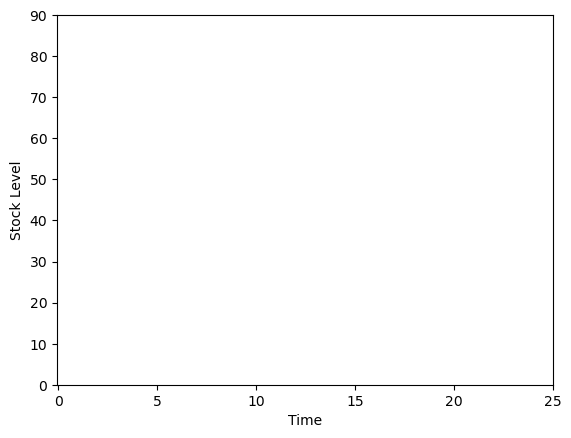

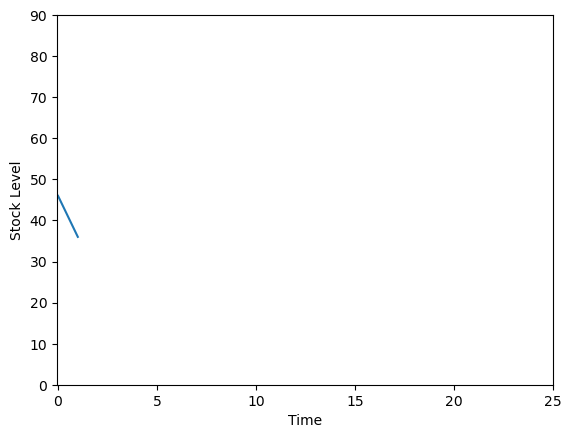

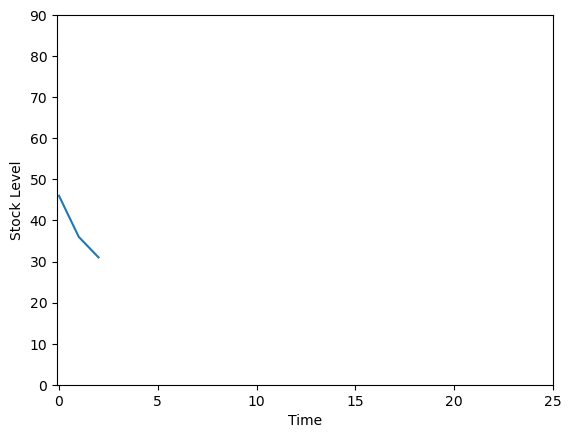

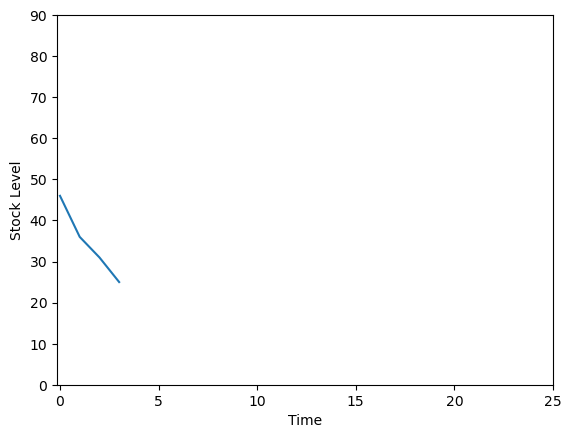

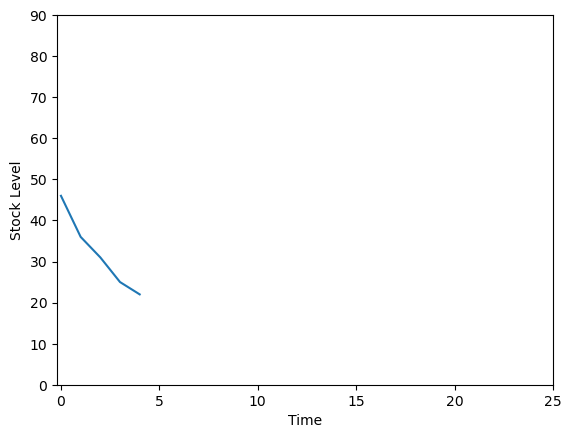

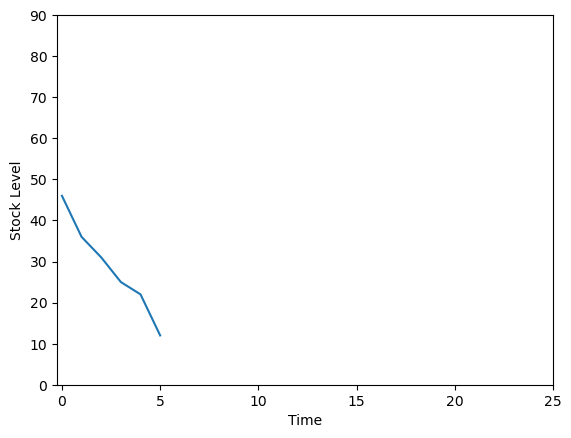

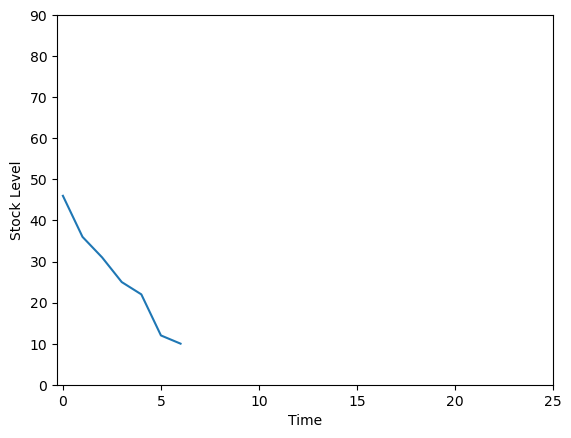

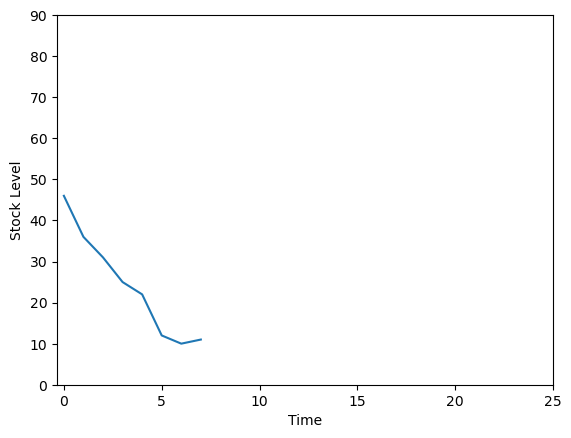

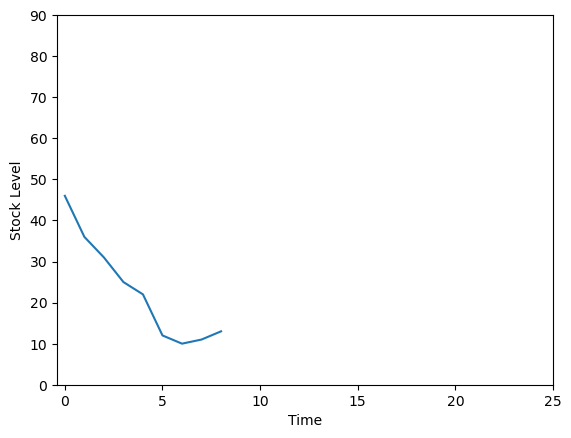

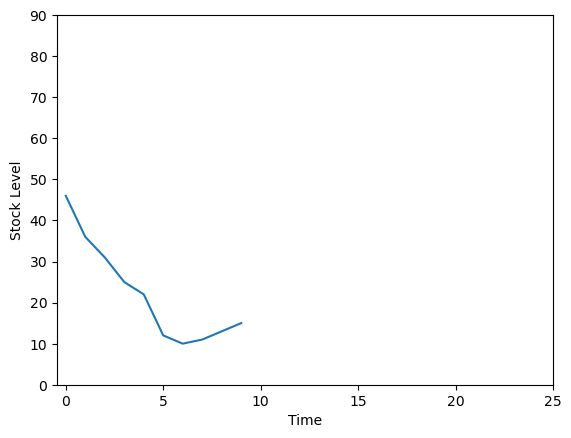

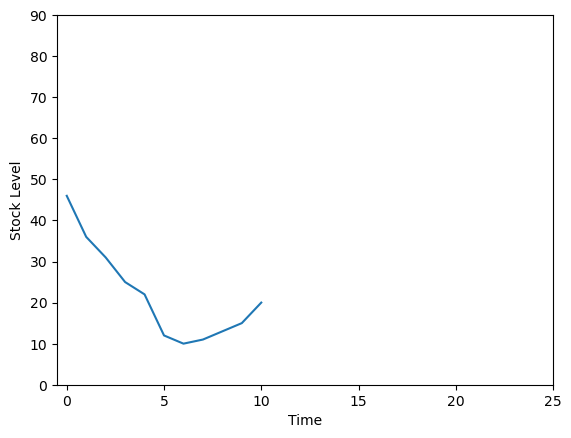

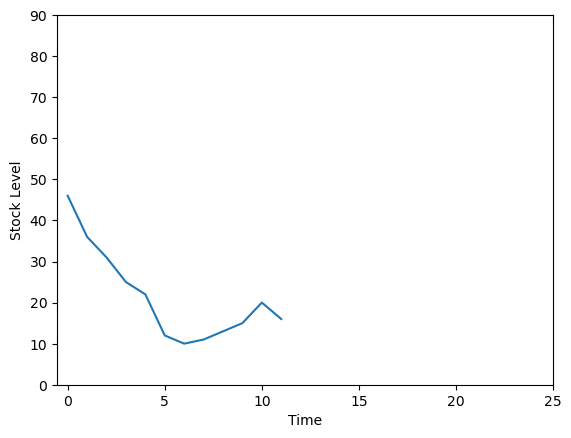

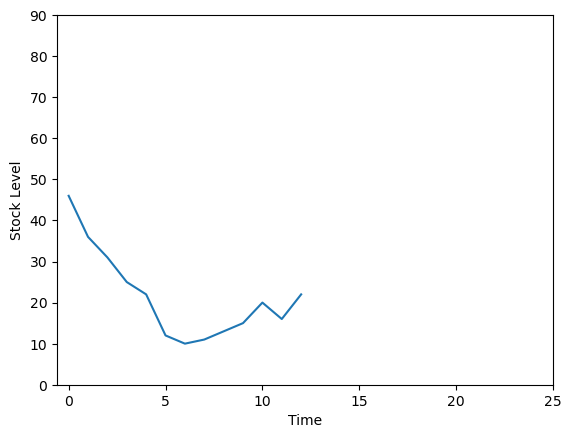

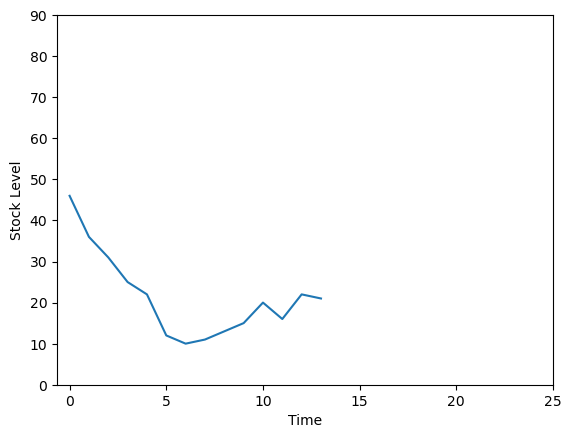

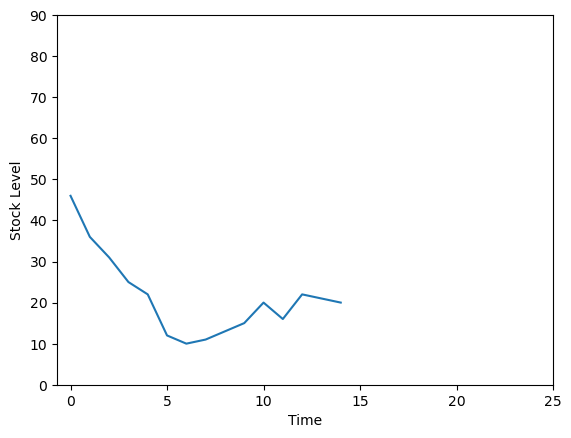

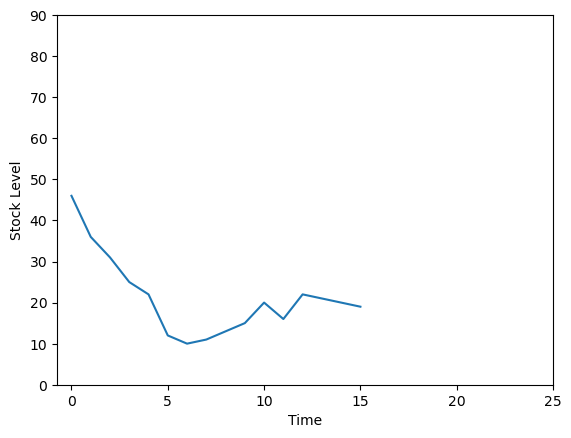

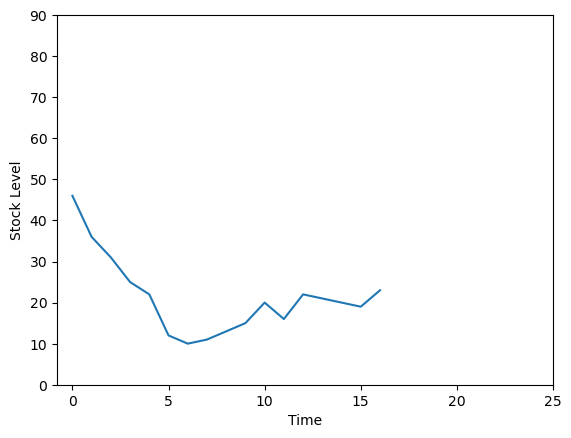

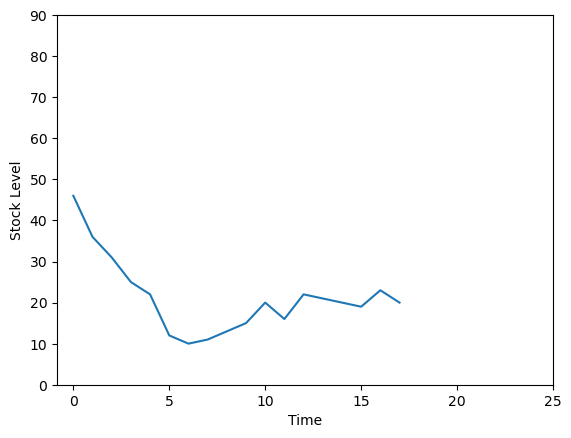

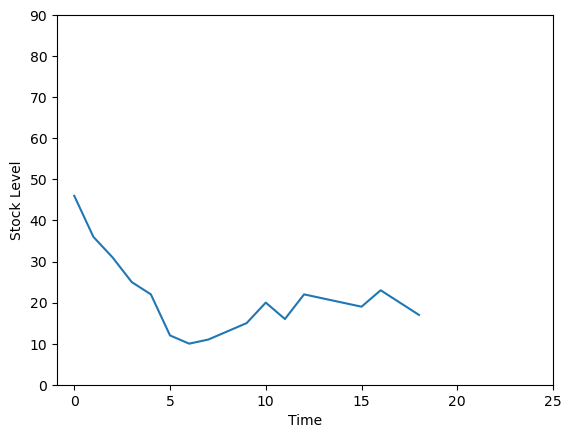

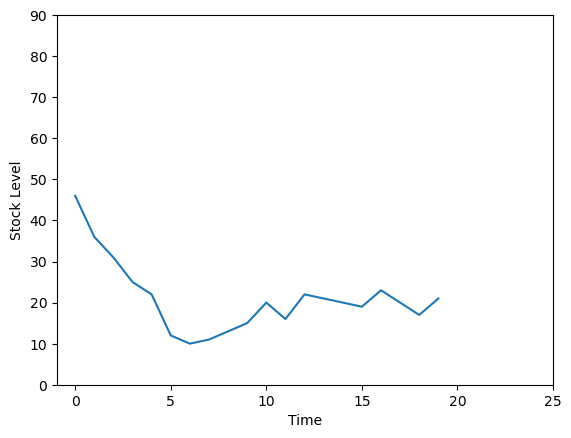

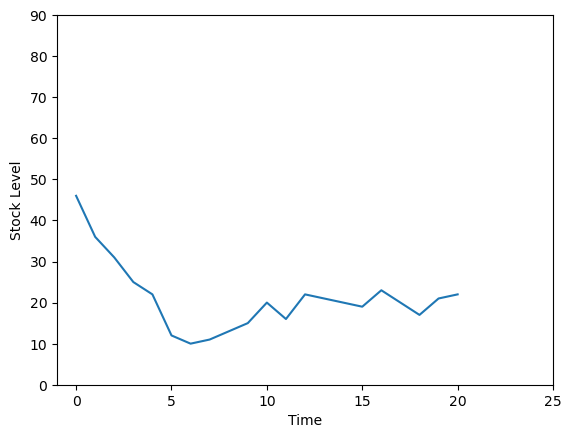

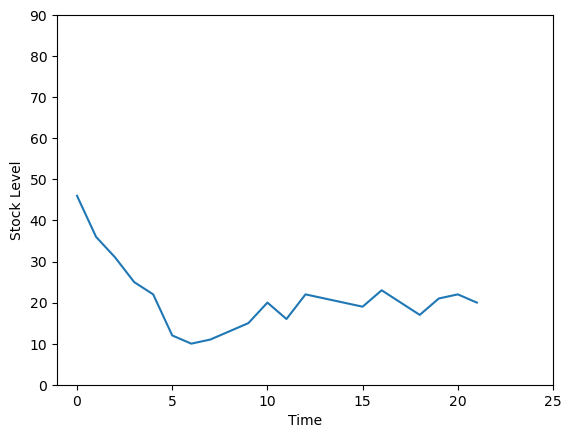

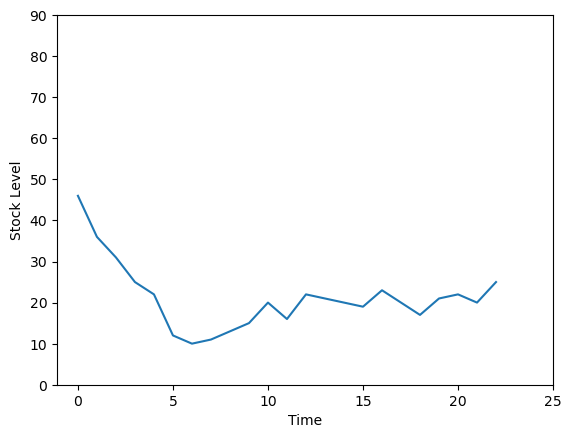

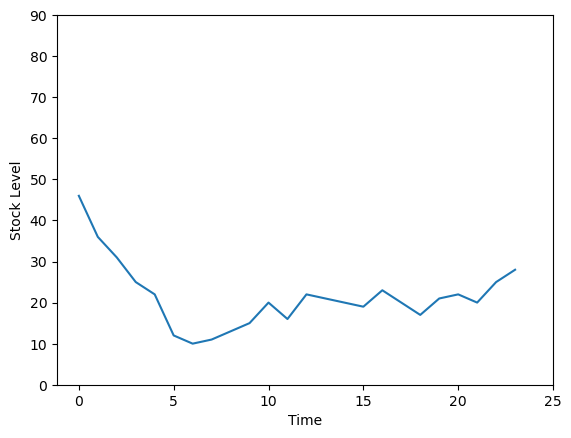

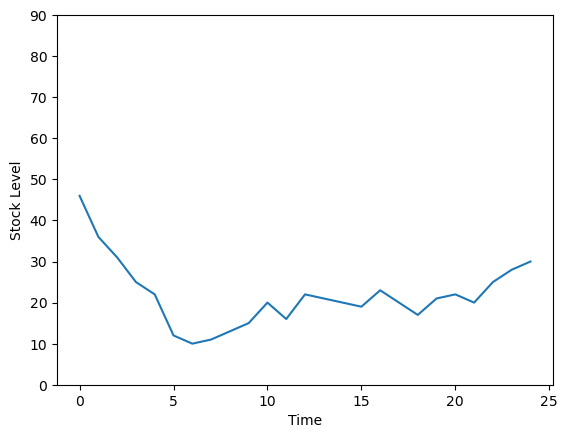

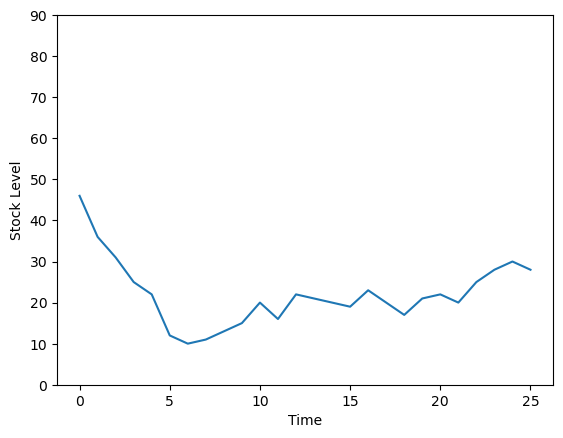

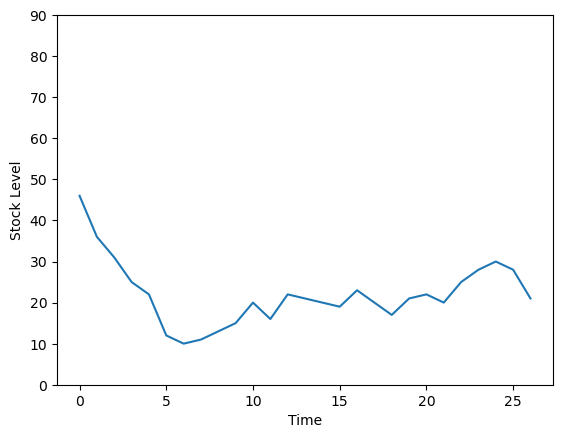

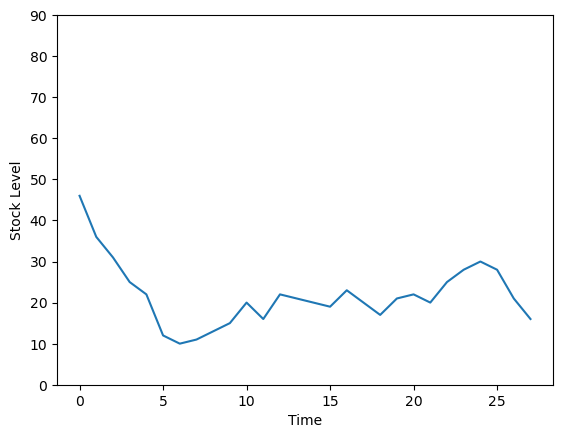

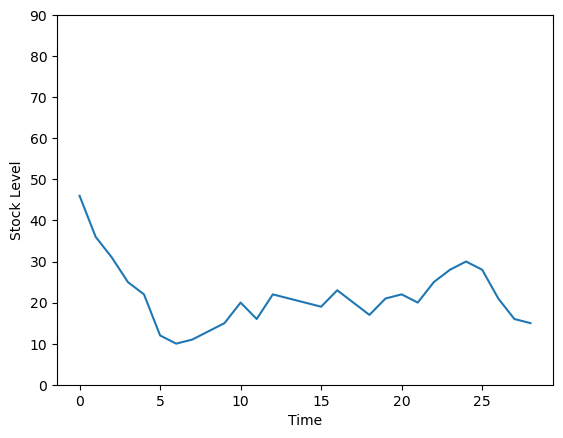

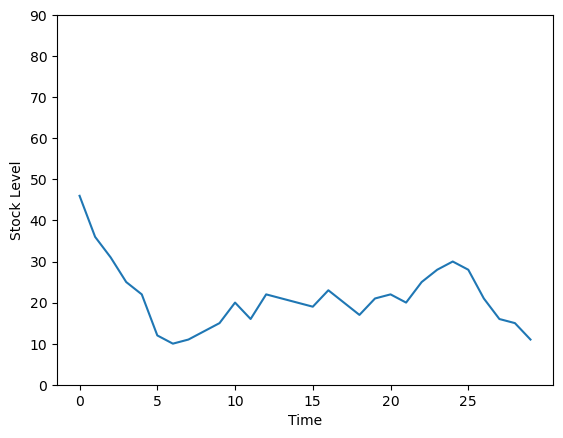

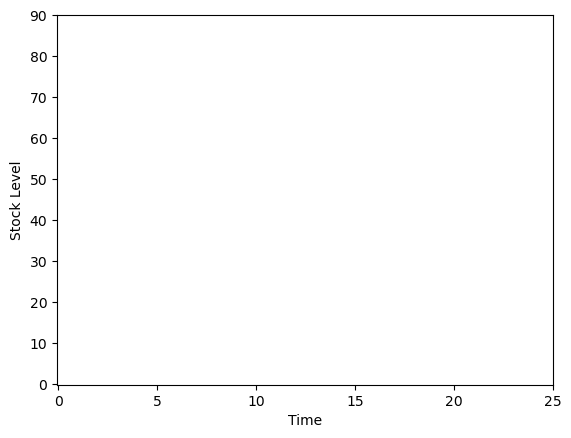

([-643.0], [31])

In [51]:
model = PPO.load(model_path, env = env)

env = SS_Mngmt_Env(render_mode="human")

evaluate_policy(model, env, n_eval_episodes=1, render=True, return_episode_rewards=True)

In [36]:
env.close()